In [0]:
%tensorflow_version 1.x

import os
import zipfile
import time
import datetime

from tqdm import tqdm_notebook

import matplotlib.pyplot as plt
import cv2
from google.colab.patches import cv2_imshow

import numpy as np

from keras.layers import Input, Conv2D, Conv2DTranspose, BatchNormalization, \
                         Activation, ReLU, MaxPooling2D
from keras import layers
from keras.models import Model
from keras.applications import vgg16
from keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
import keras.backend as K
from keras.utils import plot_model
from keras import optimizers

import tensorflow as tf

from prettytable import PrettyTable

import urllib


In [0]:
SEED = 42
np.random.seed(SEED)
tf.set_random_seed(SEED)

In [0]:
#!nvidia-smi

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
##############TEMPORARY CONSTANTS#####################
net_name = 'night'

height = 512 # 256 x 256 in original article
width = 512

batch_size = 4
steps_per_epoch = 20000
epochs = 2

learning_rate = 1e-3 

verbose_iter = 100 #set how often show training info and save test picture

# loss weigts
content_w = 2500  
style_w1 = 0.1
style_w2 = 0.1
style_w3 = 0.2
style_w4 = 0.1
tv_w = 0.01    
output_w = 0

style_img_path = '/content/drive/My Drive/colab_notebooks/Keras_Fast_Style_Transfer/fst_img/night.jpg'
test_content_img_path = '/content/drive/My Drive/colab_notebooks/Keras_Fast_Style_Transfer/fst_img/dogs.jpg' # use it to check training process
test_content_imgs_save_path = '/content/drive/My Drive/colab_notebooks/Keras_Fast_Style_Transfer/fst_img/results/' # for generated images during training loop

style_layers = ['block1_conv2', 'block2_conv2', 'block3_conv3', 'block4_conv3']
content_layer = 'block3_conv3'

model_saving_path = '/content/drive/My Drive/colab_notebooks/Keras_Fast_Style_Transfer/saved_models'

## Train model

### Data downloading

In [6]:
# show current dir
!pwd

/content


In [7]:
# download train part of COCO 2014 dataset to content folder
!wget http://images.cocodataset.org/zips/train2014.zip

--2020-03-13 15:09:09--  http://images.cocodataset.org/zips/train2014.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.216.146.35
Connecting to images.cocodataset.org (images.cocodataset.org)|52.216.146.35|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 13510573713 (13G) [application/zip]
Saving to: ‘train2014.zip’

train2014.zip       100%[===================>]  12.58G  14.2MB/s    in 16m 33s 

2020-03-13 15:25:43 (13.0 MB/s) - ‘train2014.zip’ saved [13510573713/13510573713]



In [8]:
# create dir for dataset and extract zip file there
! mkdir coco2014_train
!ls

coco2014_train	drive  sample_data  train2014.zip


In [0]:
zip_file_path = '/content/train2014.zip'
unzipped_train_path = '/content/coco2014_train/train2014'

dir_path = '/content/coco2014_train'

In [10]:
%%time
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(dir_path)

CPU times: user 30.2 s, sys: 21.6 s, total: 51.9 s
Wall time: 6min 22s


In [11]:
# create complete file pathes
files_path_list = [os.path.join(unzipped_train_path, file_name) for file_name in os.listdir(unzipped_train_path)]
files_path_list[:3]

['/content/coco2014_train/train2014/COCO_train2014_000000284020.jpg',
 '/content/coco2014_train/train2014/COCO_train2014_000000243443.jpg',
 '/content/coco2014_train/train2014/COCO_train2014_000000107735.jpg']

In [12]:
print('Samples amount:', len(files_path_list))

Samples amount: 82783


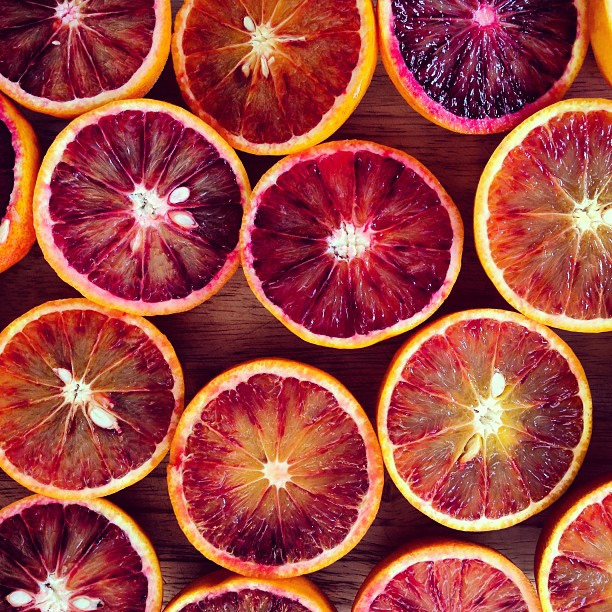

In [13]:
img_example = cv2.imread(files_path_list[np.random.randint(0, len(files_path_list))])
cv2_imshow(img_example)

### Setting up model functions

In [0]:
# Helper function

def gram_matrix(x):
    '''
    Calculate Gram matrix 
    http://pmpu.ru/vf4/dets/gram
    '''
    # K.permute_dimensions - Permutes axes in a tensor. https://www.tensorflow.org/api_docs/python/tf/keras/backend/permute_dimensions
    # K.batch_flatten - Turn a nD tensor into a 2D tensor with same 0th dimension. https://www.tensorflow.org/api_docs/python/tf/keras/backend/batch_flatten
    features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    gram = K.dot(features, K.transpose(features))
    return gram

def dummy_loss(y_true, y_pred):
  '''
  Use to initialize loss functions and compile model.
  Input variables y_true, y_pred are demanded by keras, even if they doesn`t return
  Read more here https://towardsdatascience.com/advanced-keras-constructing-complex-custom-losses-and-metrics-c07ca130a618
  '''
  return y_pred

def zero_loss(y_true, y_pred):
  '''
  ???????
  '''
  return K.variable(np.zeros(1,))

In [0]:
# Loss functions

def get_content_loss(activations, **kwargs):
  '''
  Calculate content (feature) loss of vgg16 content activation and 
  correspond layer from our model.The loss is the Euclidian distance (L2 norm).
  '''
  layer_activation, content_activation = activations
  batch_size = kwargs['batch_size']

  shape = content_activation.shape
  H, W, C = shape[1], shape[2], shape[3]

  loss = K.variable(0)
  for idx in range(batch_size):
    loss = loss + (K.sum(K.square(layer_activation[idx] - content_activation[idx])) / (H * W * C).value)
  return loss


def get_style_loss(activations, **kwargs):
  '''
  Calculate style loss.
  '''
  layer_activation, style_activation = activations
  batch_size = kwargs['batch_size']

  shape = style_activation.shape.dims
  H, W, C = shape[1], shape[2], shape[3]

  loss = K.variable(0)
  for idx in range(batch_size):
    layer_gram = gram_matrix(layer_activation[idx])
    style_gram = gram_matrix(style_activation[idx])
    loss = loss + K.sum(K.square(layer_gram - style_gram)) / ((H * W * C).value**2)
  return loss


def get_tv_loss(x, **kwargs):
  '''
   Calculate total variation loss. Reduce puzzling effect
  '''
  height = kwargs['height']
  width = kwargs['width']
  a = K.square(x[:, :height - 1, :width - 1, :] - 
               x[:, 1:, :width - 1, :])
  b = K.square(x[:, :height - 1, :width - 1, :] - 
               x[:, :height - 1, 1:, :])
  print(a.shape, b.shape)
  return K.sum(K.pow(a+b, 1.25))

### Setting up models architectures and adding VGG16 frozen weights. Compile model.

In [0]:
def residual_block(y, _nb_channels = 128, _strides = (1, 1), name_number = 1):
  shortcut = y

  #forward pass
  y = Conv2D(filters = _nb_channels, kernel_size = (3, 3), 
             strides = _strides, padding = 'same', 
             name = 're_conv1_{}'.format(name_number))(y)
  y = BatchNormalization(name = 're_batch1_{}'.format(name_number))(y)
  y = ReLU(name = 're_relu1_{}'.format(name_number))(y)

  y = Conv2D(filters = _nb_channels, kernel_size = (3, 3), 
             strides = _strides, padding = 'same',
              name = 're_conv2_{}'.format(name_number))(y)
  y = BatchNormalization(name = 're_batch2_{}'.format(name_number))(y)

  #adding shortcut
  y = layers.add([shortcut, y])
  y = ReLU(name = 're_relu2_{}'.format(name_number))(y)

  return y

In [0]:
class OutputScale(layers.Layer):

    def __init__(self, **kwargs):
        super(OutputScale, self).__init__(**kwargs)

    def build(self, input_shape):
        pass

    def call(self, x, mask=None):
        return x * 150

    def compute_output_shape(self, input_shape):
        return input_shape

In [18]:
# model schemes
%%html
<p float="left">
  <img src="https://raw.githubusercontent.com/Gooogr/Keras_Fast_Style_Transfer/master/schemes/Complete%20scheme.png" width="500" />
  <img src="https://raw.githubusercontent.com/Gooogr/Keras_Fast_Style_Transfer/master/schemes/VGG16.png" width="500" />
  <img src="https://raw.githubusercontent.com/Gooogr/Keras_Fast_Style_Transfer/master/schemes/Image%20Transform%20Net.png" width="500" />
</p>

Initialize model structure

In [0]:
# Debagging Keras model:
# http://laid.delanover.com/debugging-a-keras-neural-network/

In [20]:
K.clear_session()

In [0]:
def get_training_model(height, width, batch_size):
  '''
  Create training model (with VGG-16 part).
  Input:
    height - input image height
    width - input image width
    batch_size - batch size
  Output:
    Non-compiled Keras model
  '''
  model_input = Input(shape = (height, width, 3), name = 'model_input')

  ### Autoencoder block ###
  # Convolution sub-blocks
  c1 = Conv2D(32, (9, 9), strides = 1, padding = 'same', name = 'conv_1')(model_input)
  c1 = BatchNormalization(name = 'norm_1')(c1)
  c1 = ReLU(name = 'relu_1')(c1)
  
  c2 = Conv2D(64, (3, 3), strides = 2, padding = 'same', name = 'conv_2')(c1)
  c2 = BatchNormalization(name = 'norm_2')(c2)
  c2 = ReLU(name = 'relu_2')(c2)

  c3 = Conv2D(128, (3, 3), strides = 2, padding = 'same', name = 'conv_3')(c2)
  c3 = BatchNormalization(name = 'norm_3')(c3)
  c3 = ReLU(name = 'relu_3')(c3)

  # Residual sub-blocks
  r1 = residual_block(c3, name_number = 1)
  r2 = residual_block(r1, name_number = 2)
  r3 = residual_block(r2, name_number = 3)
  r4 = residual_block(r3, name_number = 4)
  r5 = residual_block(r4, name_number = 5)

  # Deconvolution sub-blocks
  d1 = Conv2DTranspose(64, (3, 3), strides = 2, padding='same', name = 'conv_4')(r5)
  d1 = BatchNormalization(name = 'norm_4')(d1)
  d1 = ReLU(name = 'relu_4')(d1)

  d2 = Conv2DTranspose(32, (3, 3), strides = 2, padding='same', name = 'conv_5')(d1)
  d2 = BatchNormalization(name = 'norm_5')(d2)
  d2 = ReLU(name = 'relu_5')(d2)

  c4 = Conv2D(3, (9, 9), strides = 1, padding = 'same', name = 'conv_6')(d2)
  c4 = BatchNormalization(name = 'norm_6')(c4)
  c4 = Activation(activation = 'hard_sigmoid', name = 'hard_sigmoid_1')(c4) #hard sigmoid computes faster then sigmoid
  c4 = OutputScale(name = 'model_output')(c4) 

  ### Content and style activation inputs
  #shapes correspond to VGG16 layers. Look on scheme of activations exits.
  content_activation = Input(shape = (height//4, width//4, 256))  #(64, 64, 256)

  style_activation_1 = Input(shape = (height, width, 64))         #(256, 256, 64)
  style_activation_2 = Input(shape = (height//2, width//2, 128))  #(128, 128, 128)
  style_activation_3 = Input(shape = (height//4, width//4, 256))  #(64, 64, 256)
  style_activation_4 = Input(shape = (height//8, width//8, 512))  #(32, 32, 512)

  ### VGG-16 block ###
  # Sub-block 1
  vgg_c1 = Conv2D(64, (3, 3), activation = 'relu', padding = 'same', name = 'block1_conv1')(c4) # use the same names like in the vgg16 network!
  vgg_c1 = Conv2D(64, (3, 3), activation = 'relu', padding = 'same', name = 'block1_conv2')(vgg_c1)
  style_loss1 = layers.Lambda(get_style_loss, output_shape = (1,), name = 'style_loss1', 
                              arguments = {'batch_size': batch_size})([vgg_c1, style_activation_1])
  vgg_c1 = MaxPooling2D((2, 2), strides = (2, 2), name = 'block1_pool')(vgg_c1)

  # Sub-block 2
  vgg_c2 = Conv2D(128, (3, 3), activation = 'relu', padding = 'same', name = 'block2_conv1')(vgg_c1)
  vgg_c2 = Conv2D(128, (3, 3), activation = 'relu', padding = 'same', name = 'block2_conv2')(vgg_c2)
  style_loss2 = layers.Lambda(get_style_loss, output_shape = (1,), name = 'style_loss2', 
                              arguments = {'batch_size': batch_size})([vgg_c2, style_activation_2])
  vgg_c2 = MaxPooling2D((2, 2), strides = (2, 2), name = 'block2_pool')(vgg_c2)


  # Sub-block 3
  vgg_c3 = Conv2D(256, (3, 3), activation = 'relu', padding = 'same', name = 'block3_conv1')(vgg_c2)
  vgg_c3 = Conv2D(256, (3, 3), activation = 'relu', padding = 'same', name = 'block3_conv2')(vgg_c3)
  vgg_c3 = Conv2D(256, (3, 3), activation = 'relu', padding = 'same', name = 'block3_conv3')(vgg_c3)
  style_loss3 = layers.Lambda(get_style_loss, output_shape = (1,), name = 'style_loss3', 
                              arguments = {'batch_size': batch_size})([vgg_c3, style_activation_3])


  content_loss = layers.Lambda(get_content_loss, output_shape = (1,), name = 'content_loss', 
                              arguments = {'batch_size': batch_size})([vgg_c3, content_activation])

  vgg_c3 = MaxPooling2D((2, 2), strides = (2, 2), name = 'block3_pool')(vgg_c3)

  # Sub-block 4
  vgg_c4 = Conv2D(512, (3, 3), activation = 'relu', padding = 'same', name = 'block4_conv1')(vgg_c3)
  vgg_c4 = Conv2D(512, (3, 3), activation = 'relu', padding = 'same', name = 'block4_conv2')(vgg_c4)
  vgg_c4 = Conv2D(512, (3, 3), activation = 'relu', padding = 'same', name = 'block4_conv3')(vgg_c4)
  style_loss4 = layers.Lambda(get_style_loss, output_shape = (1,), name = 'style_loss4', 
                              arguments = {'batch_size': batch_size})([vgg_c4, style_activation_4])
  vgg_c4 = MaxPooling2D((2, 2), strides = (2, 2), name = 'block4_pool')(vgg_c4)

  ### Total variation loss ###

  total_variation_loss = layers.Lambda(get_tv_loss, output_shape = (1,), name = 'tv_loss',
                                      arguments = {'width': width, 'height': height})(c4)

  ### Create model ###
  model = Model(inputs = [model_input, content_activation, style_activation_1, 
                          style_activation_2, style_activation_3, style_activation_4], 
                outputs = [content_loss, style_loss1, style_loss2, style_loss3, 
                          style_loss4, total_variation_loss, c4])
  return model

In [0]:
def get_pred_model(height, width):
  '''
  Create simplified autoencoder model, only for predictions
  Input:
    height - input image height
    width - input image width
    batch_size - batch size
  Output:
    Non-compiled Keras model
  '''
  model_input = Input(shape = (height, width, 3), name = 'model_input')

  ### Autoencoder block ###
  # Convolution sub-blocks
  c1 = Conv2D(32, (9, 9), strides = 1, padding = 'same', name = 'conv_1')(model_input)
  c1 = BatchNormalization(name = 'norm_1')(c1)
  c1 = ReLU(name = 'relu_1')(c1)
  
  c2 = Conv2D(64, (3, 3), strides = 2, padding = 'same', name = 'conv_2')(c1)
  c2 = BatchNormalization(name = 'norm_2')(c2)
  c2 = ReLU(name = 'relu_2')(c2)

  c3 = Conv2D(128, (3, 3), strides = 2, padding = 'same', name = 'conv_3')(c2)
  c3 = BatchNormalization(name = 'norm_3')(c3)
  c3 = ReLU(name = 'relu_3')(c3)

  # Residual sub-blocks
  r1 = residual_block(c3, name_number = 1)
  r2 = residual_block(r1, name_number = 2)
  r3 = residual_block(r2, name_number = 3)
  r4 = residual_block(r3, name_number = 4)
  r5 = residual_block(r4, name_number = 5)

  # Deconvolution sub-blocks
  d1 = Conv2DTranspose(64, (3, 3), strides = 2, padding='same', name = 'conv_4')(r5)
  d1 = BatchNormalization(name = 'norm_4')(d1)
  d1 = ReLU(name = 'relu_4')(d1)

  d2 = Conv2DTranspose(32, (3, 3), strides = 2, padding='same', name = 'conv_5')(d1)
  d2 = BatchNormalization(name = 'norm_5')(d2)
  d2 = ReLU(name = 'relu_5')(d2)

  c4 = Conv2D(3, (9, 9), strides = 1, padding = 'same', name = 'conv_6')(d2)
  c4 = BatchNormalization(name = 'norm_6')(c4)
  c4 = Activation(activation = 'hard_sigmoid', name = 'hard_sigmoid_1')(c4) #hard sigmoid computes faster then sigmoid
  c4 = OutputScale(name = 'model_output')(c4) 

  model = Model(inputs = model_input, outputs = c4)

  return model

In [23]:
model = get_training_model(height, width, batch_size)











(?, ?, ?, 3) (?, ?, ?, 3)


Let's load imagenet weights in our VGG16 model's part and frozen them

In [24]:
model_layers = {layer.name: layer for layer in model.layers}

vgg_imagenet = vgg16.VGG16(weights = 'imagenet', include_top = False)
vgg_imagenet_layers = {layer.name: layer for layer in vgg_imagenet.layers}

for layer in vgg_imagenet.layers:
  if layer.name in model_layers:
    # load imagenet weights in model layer
    model_layers[layer.name].set_weights(vgg_imagenet_layers[layer.name].get_weights())
    # froze layer
    model_layers[layer.name].trainable = False


58892288/58889256 [==============================] - 6s 0us/step


Compile model

In [25]:
model_loss_weights = [content_w, style_w1, style_w2, style_w3, style_w4, tv_w, output_w]
model_optimizer = optimizers.Adam(lr = learning_rate) 
                                  
model_loss = {'content_loss': dummy_loss, 'style_loss1': dummy_loss, 'style_loss2': dummy_loss,
              'style_loss3': dummy_loss, 'style_loss4': dummy_loss, 'tv_loss': dummy_loss, 
              'model_output': zero_loss}

model.compile(loss = model_loss, optimizer = model_optimizer, loss_weights = model_loss_weights)

In [0]:
## Uncomment to see model table ##

# # PrettyTable example: http://zetcode.com/python/prettytable/
# model_summary = PrettyTable()
# model_summary.field_names = ['layer name', 'input shape', 'output shape']

# for layer in model.layers:
#   model_summary.add_row([layer.name, layer.input_shape, layer.output_shape])
# print(model_summary)


In [0]:
## Uncomment to see model graph ##
#plot_model(model)

### Helper functions for model training

In [0]:
# Image processing/deprocessing functions

def preprocess_img(img_path, img_height, img_width, resize_img = True):
  ''' 
  Convert raw image to [1, img_width, imh_height, 3] image prepared to VGG16
  '''
  if resize_img:
    img = load_img(img_path, target_size = (img_height, img_width))
  else:
     img = load_img(img_path)
  img = img_to_array(img)
  img = np.expand_dims(img, axis = 0)
  img = vgg16.preprocess_input(img)
  return img


def deprocess_img(x, height, width): # Was copied from training part
  '''
  Deprocess  model output into image. Image compatible with OpenCV.
  Input:
    x - raw model output
    height - wishful image height
    width - wishful image width
  Output:
    img - result image, ready for OpenCV
  '''
  # In our case wishful height and width are equal to model input shape (256x256, 512x512 and so on). 
  # COCO dataset has different size images and we don`t need to reshape images to their initial shape during the training process
  # We will use another function to reshape test images after training.

  x = x.reshape([height, width, 3])
  # Remove zero-pixel mean value
  # Read more here: https://github.com/keras-team/keras-applications/blob/master/keras_applications/imagenet_utils.py
  x[:, :, 0] += 103.939
  x[:, :, 1] += 116.779
  x[:, :, 2] += 123.68
  # BGR -> RGB
  #x = x[:, :, ::-1] # Made a color error in OpenCV
  img = np.clip(x, 0, 255).astype('uint8')
  return img

In [0]:
# Helper function to get initial activation

def get_func_extract_vgg_activations(layer_name, width, height):
  '''
  Return function which input is a placeholder with shape [1, height, weight, 3]
  and output is selected layer output of VGG16 newtwork.
  This layer can be feeded through the placeholder.
  '''
  tensor = K.placeholder([1, height, width, 3])
  temp_model = vgg16.VGG16(input_tensor = tensor, weights = 'imagenet', 
                           include_top = False)
  for layer in temp_model.layers:
    if layer.name == layer_name:
      layer.trainable = False
      return K.function([tensor], [layer.output])

def expand_batch_input(batch_size, initial_input):
  '''
  Expand batch dimension of selected input by copy-paste initial matrix.
  [1, 256, 256, 3] -> [4, 256,  256, 3] if butch_size = 4
  Input:
    "batch_size" - nessesary amount of batches 
    "initial_input" - input that should be expanded
  Output:
    expanded input
  '''
  expanded_input = initial_input.copy()
  for step in range(batch_size - 1):
    expanded_input = np.append(expanded_input, initial_input, axis = 0)
  return expanded_input

In [0]:
def print_training_loss(history_data):
  '''
  Print out current loss.
  input:
    history_data  - keras History object. Get it from model_name.history .
  output:
    None
  '''
  print('****************************************')
  print('Training loss details')
  print('Content loss: {}'.format(history.history['content_loss_loss'][0]))
  print('Style loss_1: {}, Style loss_2: {}'.format(history.history['style_loss1_loss'][0], history.history['style_loss2_loss'][0]))
  print('Style loss_3: {}, Style loss_4: {}'.format(history.history['style_loss3_loss'][0], history.history['style_loss4_loss'][0]))
  print('Total variation loss: {}'.format(history.history['tv_loss_loss'][0]))
  print('****************************************')


def print_test_info(verbose_result):
  '''
  Print out loss information of the test image during the training loop.
  input:
    verbose_result - current model`s prediction. Contain losses information and output image.
  output:
    None
  '''
  loss_list = []
  loss_list.append(verbose_result[0][0] * content_w) 
  loss_list.append(verbose_result[1][0] * style_w1)
  loss_list.append(verbose_result[2][0] * style_w2) 
  loss_list.append(verbose_result[3][0] * style_w3) 
  loss_list.append(verbose_result[4][0] * style_w4) 
  loss_list.append(verbose_result[5][0] * tv_w) 
  current_loss = sum(loss_list)
  print('----------------------------------------')
  print('Current test image losses')
  print('Current sum loss: {}'.format(current_loss))
  print('Losses parts:')
  print('Content loss: {}'.format(loss_list[0]))
  print('Style loss_1: {}, Style loss_2: {}, \nStyle loss_3: {}, Style loss_4: {}'.format(loss_list[1], loss_list[2], loss_list[3], loss_list[4]))
  print('Total variation loss: {}'.format(loss_list[5]))
  print('----------------------------------------')

In [0]:
def save_model(model, model_name, save_path):
  '''
  Save model graph and weights.
  Input:
    model - Keras model that you wish to save
    model_name - name prefix in result files
    save_path - full path to the saving directory
  Output:
    None
  '''
  json_model = model.to_json()
  # Save json graph
  with open(os.path.join(save_path, '{}.json'.format(model_name)), 'w') as json_file:
    json_file.write(json_model)
  # Save weights
  model.save(os.path.join(save_path, '{}_weights.h5'.format(model_name)))


### Model training

In [31]:
## Getting activation to fit them in our model
# Get style activations
style_tensor = preprocess_img(style_img_path, height, width)
style_act = []
for layer_name in tqdm_notebook(style_layers):
    style_function = get_func_extract_vgg_activations(layer_name, width, height)
    style_activation = expand_batch_input(batch_size, style_function([style_tensor])[0])
    style_act.append(style_activation)

# Get content activations for test image
content_test_tensor = preprocess_img(test_content_img_path, height, width)
content_function = get_func_extract_vgg_activations(content_layer, width, height)
content_test_activation = expand_batch_input(batch_size, content_function([content_test_tensor])[0])
content_test = expand_batch_input(batch_size, content_test_tensor) 


In [32]:
datagen = ImageDataGenerator()
dummy_input = expand_batch_input(batch_size, np.array([0.0]))
start_time = time.time()
summ_time = 0

for ep in range(epochs):
  print('Epoch: ', ep)
  iters = 0

  for x in datagen.flow_from_directory(dir_path, 
                                      class_mode = None, 
                                      batch_size = batch_size, 
                                      target_size = (height, width)):
    t1 = time.time()
    x = vgg16.preprocess_input(x)
    content_act = content_function([x])[0]
    history = model.fit([x, content_act, style_act[0], style_act[1], 
                         style_act[2], style_act[3]], 
                        [dummy_input, dummy_input, dummy_input, dummy_input,
                         dummy_input, dummy_input, x], 
                        epochs = 1, verbose = 0, batch_size = batch_size) #verbose = 0, we will print info manually
    t2 = time.time()
    summ_time = t2 - t1
    iters += 1

    if iters % verbose_iter == 0:
      print()
      print('Current iteration: ', iters)

      # predict and save image on current iteration
      verbose_result = model.predict([content_test, content_test_activation, style_act[0], style_act[1], 
                         style_act[2], style_act[3]])
      print_test_info(verbose_result) # print test losses

      # verbose_image = deprocess_img(verbose_result[6], width, height)
      verbose_image = deprocess_img(verbose_result[6][0], width, height)


      cv2.imwrite(os.path.join(test_content_imgs_save_path, '{}_{}_{}_test_img.jpg'.format(net_name, iters, ep)), verbose_image)


      # print training loop info
      est_time = None               #FINISH IT

      print_training_loss(history)

    if iters > steps_per_epoch:
      break


Epoch:  0
Found 82783 images belonging to 1 classes.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Current iteration:  100
----------------------------------------
Current test image losses
Current sum loss: 12464781830.759998
Losses parts:
Content loss: 2894495312.5
Style loss_1: 1585460224.0, Style loss_2: 4184252416.0, 
Style loss_3: 3541999616.0, Style loss_4: 841613.3
Total variation loss: 257732648.96
----------------------------------------
****************************************
Training loss details
Content loss: 1383907.375
Style loss_1: 14440753152.0, Style loss_2: 25103048704.0
Style loss_3: 15168470016.0, Style loss_4: 7940537.0
Total variation loss: 30229413888.0
****************************************


KeyboardInterrupt: ignored

In [80]:
### Save results ###

pred_model = get_pred_model(height, width)

# fill pred_model by trained weights
training_model_layers = {layer.name: layer for layer in model.layers}
for layer in tqdm_notebook(pred_model.layers):
  if layer.name in training_model_layers.keys():
    layer.set_weights(training_model_layers[layer.name].get_weights())

save_model(pred_model, 'fst_night', model_saving_path)

## Predict from pre-trained model

In [0]:
# Helper functions

def get_model(model_files_dir, h5_file_name):
  '''
  Add info
  '''
  model = get_pred_model(height, width)
  model.load_weights(os.path.join(model_files_dir, h5_file_name))
  return model


# def url_to_image(url):
# 	'''
# 	Download the image, convert it to a NumPy array. Encode it into OpenCV format.
# 	'''
# 	resp = urllib.request.urlopen(url)
# 	image = np.asarray(bytearray(resp.read()), dtype="uint8")
# 	image = cv2.imdecode(image, cv2.IMREAD_COLOR)
# 	return image


def reshape_img(x, img_path, url_link = True):
  '''
  Reshape image to the original shape of input image.
  Input:
    x - image (matrix) after deprocessing
    img_path - path to the original input image
    url_link - boolean flag for understanding if img_path is file path or url link
  Output:
    img - reshaped image
  '''
  return x

In [0]:
loaded_model = get_model(model_saving_path, 'fst_night_weights.h5')


In [0]:
# # Test example
# test_img = url_to_image(url = 'https://komiinform.ru/content/news/images/184661/huge_c3dc19f9-e7b4-4a02-a0fb-8049a12dbec0_view.jpg')
# cv2_imshow(test_img)

# Пока что preprocess image умеет работать только с файлами, не url!

In [0]:
test_img_path = '/content/drive/My Drive/colab_notebooks/Keras_Fast_Style_Transfer/fst_img/test_images/bear.jpg'

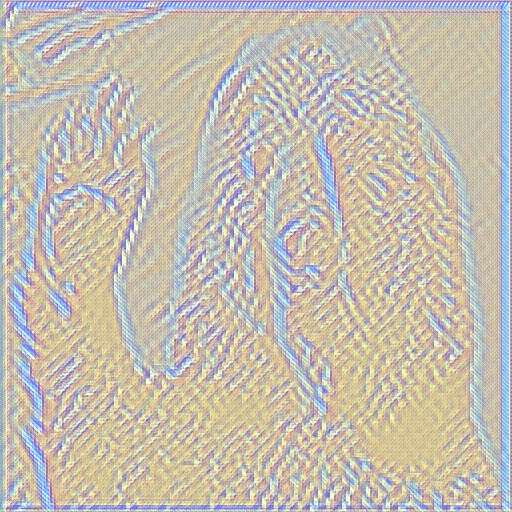

In [78]:
test_pred = loaded_model.predict(preprocess_img(test_img_path, height, width))
test_res = deprocess_img(test_pred, width, height)
cv2_imshow(test_res)

Промежуточный итог:
 - Необходимо вычислить estimated_time окончания обучения
 - Видимо нужен padding в модуле predict для избавления от рамочности
 - Добавить в preprocess_image возможность использовать url ссылки на изображение